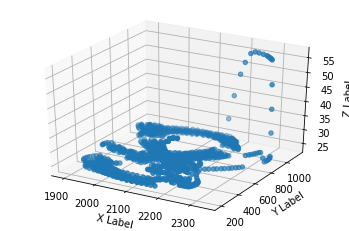

In [1]:
import numpy as np
import networkx as nx
import numpy.random as rnd
import string
import matplotlib.pyplot as plt
from matplotlib import cm

matX = np.genfromtxt('q3dm1-path2.csv',delimiter=',')

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matX[:,1],matX[:,0],matX[:,2], marker='o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

## task 17.1: SOMs of peculiar topology

In [2]:
def initRingSOM(matX, k, start=1):
    G = nx.generators.lattice.grid_2d_graph(k, start, periodic=True)
    G = nx.convert_node_labels_to_integers(G)
    m, n = matX.shape
    smpl = rnd.choice(m, k, replace=False)
    for i, v in enumerate(G):
        G.nodes[v]['w'] = matX[smpl[i],:]
    return G

def trainSOM(matX, G, tmax=1000, sigma0=1., eta0=1.):
    m, n = matX.shape
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    #
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, m, size=tmax)
    for t in range(tmax):
        # sample a point x, i.e. a row of matrix X
        vecX = matX[smpl[t],:]
        # determine the best matching unit
        b = np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G])
        # update the learning rate
        eta = eta0 * (1. - t/tmax)
        # update the topological adaption rate
        sigma = sigma0 * np.exp(-t/tmax)
        # update all weights
        for i, v in enumerate(G):
            # evaluate neighborhood function
            h = np.exp(-0.5 * matD[b,i] / sigma**2)
            G.nodes[v]['w'] += eta * h * (vecX - G.nodes[v]['w'])
    return G

In [3]:
G1 = initRingSOM(matX, 10)
G2 = initRingSOM(matX, 10)
G = nx.disjoint_union(G1,G2)
G.add_edge(9, 10)

G.edges()

EdgeView([(0, 1), (0, 9), (1, 2), (2, 3), (3, 4), (4, 5), (5, 6), (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (10, 19), (11, 12), (12, 13), (13, 14), (14, 15), (15, 16), (16, 17), (17, 18), (18, 19)])

In [4]:
SOM1 = trainSOM(matX, G, tmax=10000)

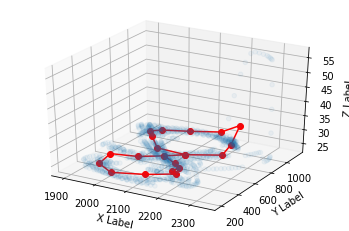

In [5]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matX[:,1],matX[:,0],matX[:,2], marker='o',alpha=0.05)

neurons = []

# Connect 
neurons.append(SOM1.nodes[9]['w'])

for i in range(len(SOM1.nodes())):
    neurons.append(SOM1.nodes[i]['w'])

neurons.append(SOM1.nodes[10]['w'])
neurons = np.array(neurons)

ax.plot(neurons[:,1],neurons[:,0],neurons[:,2],'r-o')


ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()

In [6]:
## task 17.2: SOM batch training

In [7]:
def batch_trainSOM(matX, G, tmax=1000, b_size=50, sigma0=1., eta0=1.):
    m, n = matX.shape
    # compute matrix of squared path length distances between neurons
    # NOTE: networkx returns a numpy matrix, but we want a numpy array
    #
    matD = np.asarray(nx.floyd_warshall_numpy(G))**2
    # a list of tmax random indices into the columns of matrix X
    smpl = rnd.randint(0, m, size=tmax)
    for t in range(int(tmax//b_size)):
        # Create H matrix
        h_batch = np.zeros((b_size,len(G)))
        
        ## Batch compute
        for batch in range(b_size):
            # get index
            idx = t*b_size + batch
            # sample a point x, i.e. a row of matrix X
            vecX = matX[smpl[idx],:]
            # determine the best matching unit
            b = np.argmin([np.sum((G.nodes[v]['w'] - vecX)**2) for v in G])
            # update the topological adaption rate
            sigma = sigma0 * np.exp(-idx/tmax)

            # compute all h
            for i, v in enumerate(G):
                # evaluate neighborhood function
                h = np.exp(-0.5 * matD[b,i] / sigma**2)
                h_batch[batch,i] =  h
    
        ## Batch update
        vecXs = matX[smpl[t*b_size: t*b_size + b_size],:]
        # update all weights
        for i, v in enumerate(G):
            num = np.sum(vecXs * np.array([h_batch[:,i]]).T, axis=0)
            G.nodes[v]['w'] = num / np.sum(h_batch[:,i])

    return G

In [8]:
SOM1 = batch_trainSOM(matX, G, tmax=50000, b_size=50)

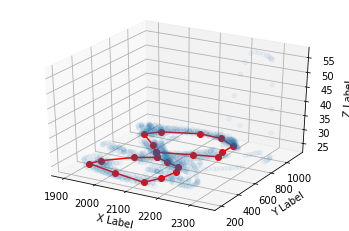

In [9]:
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(matX[:,1],matX[:,0],matX[:,2], marker='o',alpha=0.05)

neurons = []

# Connect 
neurons.append(SOM1.nodes[9]['w'])

for i in range(len(SOM1.nodes())):
    neurons.append(SOM1.nodes[i]['w'])

neurons.append(SOM1.nodes[10]['w'])
neurons = np.array(neurons)

ax.plot(neurons[:,1],neurons[:,0],neurons[:,2],'r-o')

ax.set_xlabel('X Label')
ax.set_ylabel('Y Label')
ax.set_zlabel('Z Label')

plt.show()